# Configs

In [1]:
import random


random.seed(27)

splitPartCount = 5
splitSeed = 27
hoursPerWindow = 1

# Load data

In [2]:
from utils.prepare_data import getMonitoredPatients
from pandas import Timedelta


patients = getMonitoredPatients()
patients.removePatientAkiEarly(Timedelta(hours=12))

print("Total ", len(patients))
print("AKI ", sum([1 for p in patients if p.akdPositive]))
print("Ratio ", sum([1 for p in patients if p.akdPositive]) / len(patients))

Total  1124
AKI  392
Ratio  0.3487544483985765


# Transformer

### Model

In [3]:
import torch
import torch.nn as nn


class TransformerEncoder(nn.Module):
    def __init__(
        self,
        n_feat,
        num_encoder_layers,
        dim_feedforward,
    ):
        super(TransformerEncoder, self).__init__()
        
        self.fc1 = nn.Linear(n_feat, 32)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=32,
            batch_first=True,
            nhead=8,
            dim_feedforward=dim_feedforward,
            dropout=0.3,
            activation="relu",
        )
        self.transformer_encoder = nn.TransformerEncoder(
            self.encoder_layer, num_layers=num_encoder_layers
        )
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.dropout(x)
        output = self.transformer_encoder(x)
        return output


class TransformerOnly(nn.Module):
    def __init__(
        self,
        n_feats,
        num_encoder_layers,
        dim_feedforward,
    ):
        super(TransformerOnly, self).__init__()
        self.transformer_encoder = TransformerEncoder(
            n_feat=n_feats,
            num_encoder_layers=num_encoder_layers,
            dim_feedforward=dim_feedforward,
        )
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.LazyLinear(1)

    def forward(self, x):
        x = self.transformer_encoder(x)

        # Permute for pooling: (batch_size, seq_len, d_model) -> (batch_size, d_model, seq_len)
        x = x.permute(0, 2, 1)

        # Global Average Pooling
        x = self.pooling(x)
        
        # Flatten
        x = torch.flatten(x, 1)

        x = self.fc1(x)
        return x


model = TransformerOnly(
    n_feats=512,
    num_encoder_layers=2,
    dim_feedforward=200,
)

# Example input (batch_size, seq_len, d_model)
src = torch.rand(32, 100, 512)  # Batch of 32 sequences, each of length 100
output = model(src)
print(output.shape)  # Expected output: (32, 1)

torch.Size([32, 1])


### Train and eval

In [4]:
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc,
)
from utils.class_voter import combineProbas
from utils.dl_train_test import infer, train
from utils.prepare_data import (
    DeepLearningDataPreparer,
    trainValTestPatients,
)
import numpy as np


accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
specificity_score_list = []
sensitivity_score_list = []
auc_pr_list = []

train_loss_list = []
val_loss_list = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batchSize = 64

for i, (trainValGenerator, testPatients) in enumerate(
    trainValTestPatients(patients, splitSeed)
):
    models = []
    probas = []
    for ii, (trainPatients, valPatients) in enumerate(trainValGenerator):
        preparer = DeepLearningDataPreparer(
            hoursPerWindows=hoursPerWindow,
            fromHour=0,
            toHour=12,
        )

        (
            (npTrainX, staticTrainX, trainY),
            (npValX, staticValX, valY),
            (npTestX, staticTestX, testY),
        ) = preparer.trainValTest(trainPatients, valPatients, testPatients)

        # neg, pos = np.bincount(trainY)
        # weight0 = (1 / neg) * (len(trainY)) / 2.0
        # weight1 = (1 / pos) * (len(trainY)) / 2.0
        # weight = {0: weight0, 1: weight1}

        # expand static data to be same size as time series data
        staticTrainX = np.expand_dims(staticTrainX, axis=1)
        staticTrainX = np.repeat(staticTrainX, npTrainX.shape[1], axis=1)

        staticTestX = np.expand_dims(staticTestX, axis=1)
        staticTestX = np.repeat(staticTestX, npTestX.shape[1], axis=1)

        staticValX = np.expand_dims(staticValX, axis=1)
        staticValX = np.repeat(staticValX, npValX.shape[1], axis=1)
        # append to npX
        npTrainX = np.concatenate([npTrainX, staticTrainX], axis=2)
        npTestX = np.concatenate([npTestX, staticTestX], axis=2)
        npValX = np.concatenate([npValX, staticValX], axis=2)

        # create data loader
        trainLoader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(
                torch.tensor(npTrainX).float(),
                torch.tensor(trainY).unsqueeze(1).float(),
            ),
            batch_size=batchSize,
            shuffle=True,
        )
        valLoader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(
                torch.tensor(npValX).float(),
                torch.tensor(valY).unsqueeze(1).float(),
            ),
            batch_size=batchSize,
            shuffle=False,
        )
        testLoader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(
                torch.tensor(npTestX).float(),
                torch.tensor(testY).unsqueeze(1).float(),
            ),
            batch_size=batchSize,
            shuffle=False,
        )

        model = TransformerOnly(
            n_feats=npTrainX.shape[2],
            num_encoder_layers=2,
            dim_feedforward=124,
        )
        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

        _, trainLosses, valLosses = train(
            model,
            device,
            trainLoader,
            valLoader,
            criterion,
            optimizer,
            epochs=50,
            earlyStopping=10,
        )

        models.append(model)
        train_loss_list.append(trainLosses)
        val_loss_list.append(valLosses)

        predProbas, _ = infer(model, device, testLoader)
        probas.append(predProbas.detach().cpu().numpy())
        torch.save(model.state_dict(), f"result/transformer_only_model/{i}_{ii}.pt")

    # calculate final probas, auc, accuracy, precision, recal
    finalYProbas = np.apply_along_axis(combineProbas, 0, np.array(probas))
    finalYPred = np.where(finalYProbas > 0.5, 1, 0)
    tn, fp, fn, tp = confusion_matrix(testY, finalYPred).ravel()
    precision_vals, recall_vals, _ = precision_recall_curve(testY, finalYProbas)

    accuracy_score_list.append(accuracy_score(testY, finalYPred))
    specificity_score_list.append(tn / (tn + fp))
    precision_score_list.append(precision_score(testY, finalYPred))
    recall_score_list.append(recall_score(testY, finalYPred))
    auc_score_list.append(roc_auc_score(testY, finalYProbas))
    auc_pr_list.append(auc(recall_vals, precision_vals))

Epoch 1/50 Train Loss: 0.6593 Val Loss: 0.7603
Epoch 2/50 Train Loss: 0.5398 Val Loss: 0.7619
Epoch 3/50 Train Loss: 0.4994 Val Loss: 0.7498
Epoch 4/50 Train Loss: 0.4808 Val Loss: 0.7403
Epoch 5/50 Train Loss: 0.4751 Val Loss: 0.7380
Epoch 6/50 Train Loss: 0.4740 Val Loss: 0.7413
Epoch 7/50 Train Loss: 0.4657 Val Loss: 0.7366
Epoch 8/50 Train Loss: 0.4668 Val Loss: 0.7334
Epoch 9/50 Train Loss: 0.4624 Val Loss: 0.7395
Epoch 10/50 Train Loss: 0.4582 Val Loss: 0.7326
Epoch 11/50 Train Loss: 0.4563 Val Loss: 0.7377
Epoch 12/50 Train Loss: 0.4520 Val Loss: 0.7387
Epoch 13/50 Train Loss: 0.4524 Val Loss: 0.7326
Epoch 14/50 Train Loss: 0.4501 Val Loss: 0.7396
Epoch 15/50 Train Loss: 0.4407 Val Loss: 0.7326
Epoch 16/50 Train Loss: 0.4450 Val Loss: 0.7287
Epoch 17/50 Train Loss: 0.4437 Val Loss: 0.7343
Epoch 18/50 Train Loss: 0.4316 Val Loss: 0.7313
Epoch 19/50 Train Loss: 0.4330 Val Loss: 0.7329
Epoch 20/50 Train Loss: 0.4292 Val Loss: 0.7319
Epoch 21/50 Train Loss: 0.4323 Val Loss: 0.7323
E

Epoch 10/50 Train Loss: 0.4661 Val Loss: 0.7102
Epoch 11/50 Train Loss: 0.4668 Val Loss: 0.7099
Epoch 12/50 Train Loss: 0.4663 Val Loss: 0.7095
Epoch 13/50 Train Loss: 0.4660 Val Loss: 0.7104
Epoch 14/50 Train Loss: 0.4659 Val Loss: 0.7097
Epoch 15/50 Train Loss: 0.4676 Val Loss: 0.7097
Epoch 1/50 Train Loss: 0.6185 Val Loss: 0.7407
Epoch 2/50 Train Loss: 0.5348 Val Loss: 0.7244
Epoch 3/50 Train Loss: 0.5014 Val Loss: 0.7139
Epoch 4/50 Train Loss: 0.4984 Val Loss: 0.7186
Epoch 5/50 Train Loss: 0.4872 Val Loss: 0.7200
Epoch 6/50 Train Loss: 0.4826 Val Loss: 0.7255
Epoch 7/50 Train Loss: 0.4748 Val Loss: 0.7229
Epoch 8/50 Train Loss: 0.4768 Val Loss: 0.7309
Epoch 9/50 Train Loss: 0.4720 Val Loss: 0.7308
Epoch 10/50 Train Loss: 0.4656 Val Loss: 0.7290
Epoch 11/50 Train Loss: 0.4682 Val Loss: 0.7289
Epoch 12/50 Train Loss: 0.4728 Val Loss: 0.7287
Epoch 13/50 Train Loss: 0.4693 Val Loss: 0.7297
Epoch 14/50 Train Loss: 0.4741 Val Loss: 0.7297
Epoch 1/50 Train Loss: 0.6194 Val Loss: 0.7431
Ep

In [5]:
print(f"AUC: {np.mean(auc_score_list)} +- {np.std(auc_score_list)}", auc_score_list)
print(f"Accuracy: {np.mean(accuracy_score_list)} +- {np.std(accuracy_score_list)}", accuracy_score_list)
print(f"Specificity: {np.mean(specificity_score_list)} +- {np.std(specificity_score_list)}", specificity_score_list)
print(f"Precision: {np.mean(precision_score_list)} +- {np.std(precision_score_list)}", precision_score_list)
print(f"Recall: {np.mean(recall_score_list)} +- {np.std(recall_score_list)}", recall_score_list)
print(f"AUC PR: {np.mean(auc_pr_list)} +- {np.std(auc_pr_list)}", auc_pr_list)

AUC: 0.814095035870408 +- 0.013734577974654265 [np.float64(0.8276643990929705), np.float64(0.7990580847723704), np.float64(0.8272932200450841), np.float64(0.8202705045951101), np.float64(0.7961889708465051)]
Accuracy: 0.757968253968254 +- 0.029262609718520013 [0.7866666666666666, 0.7333333333333333, 0.7688888888888888, 0.7866666666666666, 0.7142857142857143]
Specificity: 0.808759668250862 +- 0.023172654888187264 [np.float64(0.8095238095238095), np.float64(0.7959183673469388), np.float64(0.821917808219178), np.float64(0.8424657534246576), np.float64(0.773972602739726)]
Precision: 0.6498975994567693 +- 0.041877143167414435 [0.6744186046511628, 0.6153846153846154, 0.6708860759493671, 0.7012987012987013, 0.5875]
Recall: 0.6631937682570594 +- 0.05079074759152218 [0.7435897435897436, 0.6153846153846154, 0.6708860759493671, 0.6835443037974683, 0.6025641025641025]
AUC PR: 0.6990281705942687 +- 0.024595376556608477 [np.float64(0.7020442389485537), np.float64(0.6832664296528892), np.float64(0.74

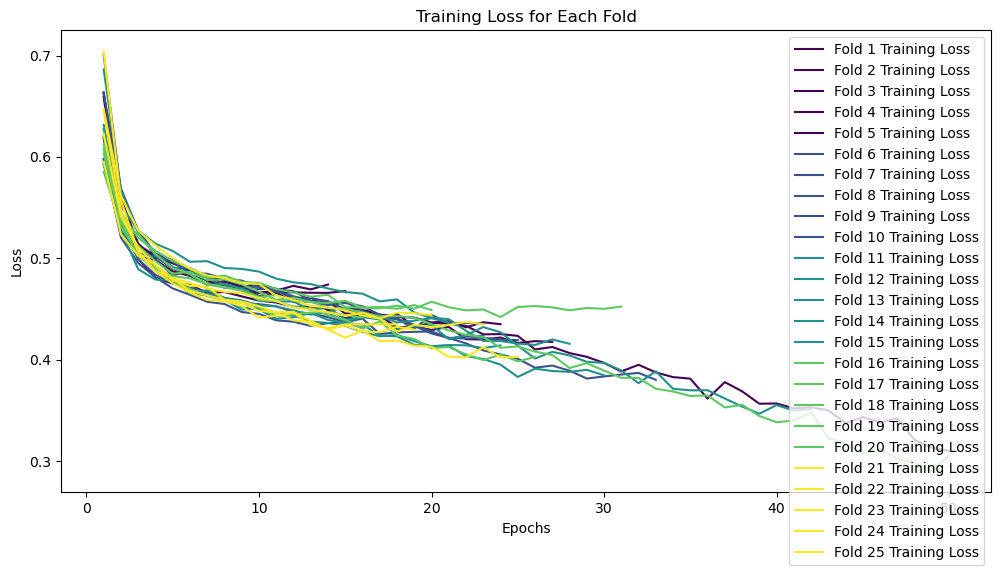

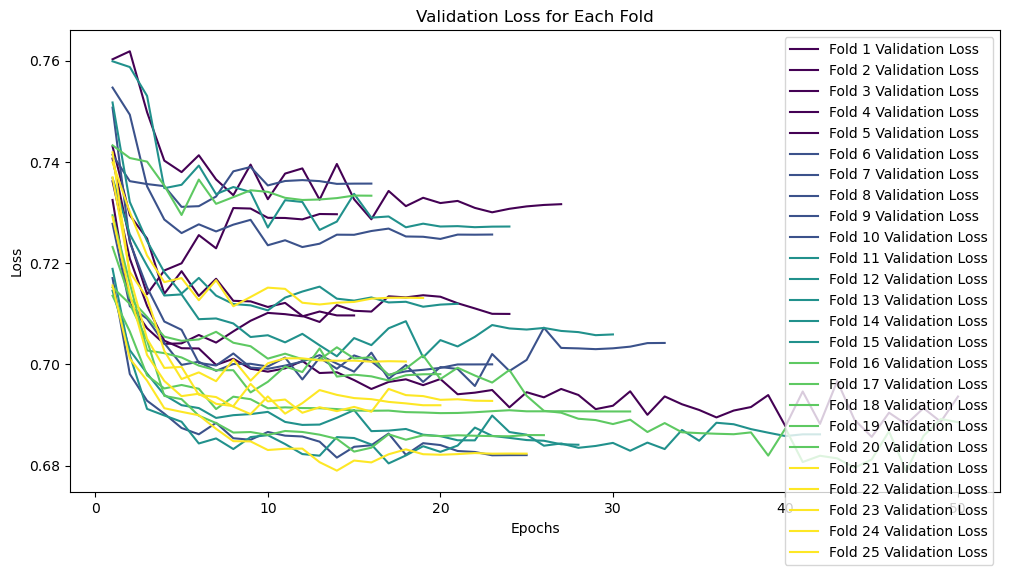

In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm


plt.figure(figsize=(12, 6))
colors = cm.viridis(np.linspace(0, 1, 5))
for i, train_loss in enumerate(train_loss_list):
    plt.plot(
        range(1, len(train_loss) + 1),
        train_loss,
        label=f"Fold {i+1} Training Loss",
        color=colors[i // 5],
    )
plt.title("Training Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("result/transformer_only_train_loss.svg")
plt.show()

# Plot the validation loss for each fold
plt.figure(figsize=(12, 6))
for i, val_loss in enumerate(val_loss_list):
    plt.plot(
        range(1, len(val_loss) + 1),
        val_loss,
        label=f"Fold {i+1} Validation Loss",
        color=colors[i // 5],
    )
plt.title("Validation Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("result/transformer_only_val_loss.svg")
plt.show()